<a href="https://colab.research.google.com/github/mangare91/Drug_Discover_Portifolio_projects/blob/main/project1_2_descriptors_modelling_exploratoryanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Load bioactivity data**

In [185]:
import pandas as pd

In [186]:
df = pd.read_csv('bioactivity_data_preprocessed.csv')

## **Calculate Lipinski descriptors**
The Lipinski's Rule stated the following: (for evaluation of druglikeness of the compound)
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### **Import libraries**

In [6]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [7]:
! pip install seaborn
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import r2_score, mean_squared_error

### **Calculate descriptors**

Here we can generate various descriptors like molecular weight, polar surface area, LogP, number of hydrogen bond donors, number of hydrogen bond acceptors, number of aromatic rings, rotatable bonds etc. Here, for our analysis we have chosen MW, LogP, HBA and HBD as these are the four parameters in the Lipinski rule of five to determine the druglikeness of the compounds.

In [187]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [188]:
df_lipinski = lipinski(df.canonical_smiles)

### **Combine DataFrames**

In [189]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
128,338.359,3.40102,0.0,5.0
129,296.366,3.44330,0.0,3.0
130,276.291,4.09564,0.0,3.0
131,278.307,3.29102,0.0,3.0


In [190]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate
...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive


In [191]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [192]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive,338.359,3.40102,0.0,5.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive,296.366,3.44330,0.0,3.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive,276.291,4.09564,0.0,3.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive,278.307,3.29102,0.0,3.0


### **Convert IC50 to pIC50 (Normalization of Bioactivity values)**

In [194]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [195]:
df_combined.standard_value.describe()

count    1.330000e+02
mean     8.017926e+12
std      3.344888e+13
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      3.311311e+14
Name: standard_value, dtype: float64

In [196]:
-np.log10( (10**-9)* 100000000 )

1.0

In [197]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [198]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [199]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,2000.0
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,10700.0


In [200]:
df_norm.standard_value_norm.describe()

count    1.330000e+02
mean     2.110164e+07
std      4.089714e+07
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      1.000000e+08
Name: standard_value_norm, dtype: float64

In [201]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


In [202]:
df_final.pIC50.describe()

count    133.000000
mean       4.060148
std        1.783762
min        1.000000
25%        3.522879
50%        4.628932
75%        4.970616
max        7.301030
Name: pIC50, dtype: float64

### **Removing the 'intermediate' bioactivity class**

In [203]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0.0,5.0,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0.0,3.0,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0.0,3.0,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0.0,3.0,4.970616


In [204]:
#saving data that will be needed for data visualization to a csv file
finaldf=df_2class[['bioactivity_class','MW','LogP','NumHDonors','NumHAcceptors','pIC50']]
finaldf.to_csv('dataforvisualization.csv', index=False)

In [205]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2020-10-28 08:31:08--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2020-10-28 08:31:08--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M  42.3MB/s    in 0.6s    

2020-10-28 08:31:09 (42.3 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2020-10-28 08:31:09--  https://github.com

In [207]:
!unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [208]:
df_2class.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [210]:
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [211]:
! cat molecule.smi | head -5

Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21	CHEMBL187579
O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21	CHEMBL188487
O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21	CHEMBL185698
O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21	CHEMBL426082
O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-]	CHEMBL187717


In [212]:
 cat molecule.smi | wc -l 

133


In [214]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [215]:
! bash padel.sh

Processing CHEMBL187579 in molecule.smi (1/133). 
Processing CHEMBL188487 in molecule.smi (2/133). 
Processing CHEMBL185698 in molecule.smi (3/133). Average speed: 2.11 s/mol.
Processing CHEMBL426082 in molecule.smi (4/133). Average speed: 1.10 s/mol.
Processing CHEMBL187717 in molecule.smi (5/133). Average speed: 0.91 s/mol.
Processing CHEMBL365134 in molecule.smi (6/133). Average speed: 0.77 s/mol.
Processing CHEMBL187598 in molecule.smi (7/133). Average speed: 0.72 s/mol.
Processing CHEMBL365469 in molecule.smi (9/133). Average speed: 0.61 s/mol.
Processing CHEMBL190743 in molecule.smi (8/133). Average speed: 0.64 s/mol.
Processing CHEMBL191575 in molecule.smi (11/133). Average speed: 0.54 s/mol.
Processing CHEMBL188983 in molecule.smi (10/133). Average speed: 0.58 s/mol.
Processing CHEMBL370923 in molecule.smi (12/133). Average speed: 0.52 s/mol.
Processing CHEMBL194398 in molecule.smi (13/133). Average speed: 0.51 s/mol.
Processing CHEMBL196635 in molecule.smi (14/133). Average sp

In [218]:
df_X_matrix = pd.read_csv('descriptors_output.csv')

In [219]:
df_X_matrix

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL187579,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL188487,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL185698,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL426082,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL187717,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129,CHEMBL187460,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
130,CHEMBL363535,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
131,CHEMBL227075,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [220]:
df_X_matrix = df_X_matrix.drop(columns=['Name'])
df_X_matrix

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
130,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
131,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [222]:
df_y = df_norm['pIC50']
df_y.dropna(inplace=True)

In [223]:
final_dataset = pd.concat([df_X_matrix,df_y], axis=1)

In [224]:
missdata = df.isnull().values.any()
print(missdata)

False


In [225]:
if missdata == True:
    print('# of missing values:', final_dataset.isnull().values.sum())
else:
    print('No missing data')

No missing data


In [226]:
final_dataset.isnull().sum()

PubchemFP0      0
PubchemFP1      0
PubchemFP2      0
PubchemFP3      0
PubchemFP4      0
               ..
PubchemFP877    0
PubchemFP878    0
PubchemFP879    0
PubchemFP880    0
pIC50           0
Length: 882, dtype: int64

In [227]:
final_dataset = final_dataset.dropna(axis=0)

In [228]:
final_dataset

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.142668
1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.026872
2,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.869666
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.882397
4,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.698970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.974694
129,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.995679
130,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.939302
131,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.970616


In [229]:
final_dataset.to_csv('final_dataset,csv', index=False)

#MODELLING

In [230]:
final_dataset = pd.read_csv('final_dataset,csv')

In [231]:
x = final_dataset.drop('pIC50', axis=1).copy()
y = final_dataset.pIC50.copy()

In [233]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
x = selection.fit_transform(x)

In [234]:
x.shape

(133, 200)

In [235]:
y.shape

(133,)

# Regression Models

## Splitting into train and test datasets

In [290]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=2)
print(f'train: {x_train.size}')
print(f'test: {x_test.size}')

train: 21200
test: 5400


In [288]:
#verifying that the feature matrix is of the right shape
x_test.shape

(40, 200)

In [240]:
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

## Linear Regression

In [291]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)
y_pred1=regressor.predict(x_test)
r2_lr = r2_score(y_test, y_pred1)
mse_lr = mean_squared_error(y_test, y_pred1)
mae_lr = mean_absolute_error(y_test, y_pred1)
print("r2_score:  ", r2_lr)
print("MSE:  ", mse_lr)
print("MAE: ", mae_lr)

r2_score:   -3.496886846181308e+24
MSE:   9.296996038394748e+24
MAE:  1827760571974.461


In [276]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred1))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))

Mean Absolute Error: 1827760571974.461
Mean Squared Error: 9.296996038394748e+24
Root Mean Squared Error: 3049097577709.6323


Text(0, 0.5, 'pIC50')

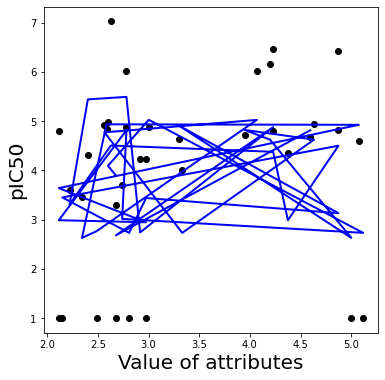

In [91]:
plt.figure(figsize=(6,6))
plt.scatter(xvalueslist+constant,y_test,color='black')
plt.plot(xvalueslist+constant,y_pred1,color='blue', linewidth=2)
plt.xlabel('Value of attributes',size=20)
plt.ylabel('pIC50',size=20)

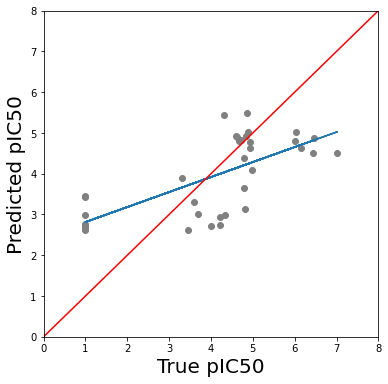

In [92]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred1,color='grey')
m, b = np.polyfit(y_test, y_pred1, 1)
plt.plot(y_test, m*(y_test) + b)
plt.plot(np.linspace(0,10),np.linspace(0,10),color='red')
plt.xlabel('True pIC50',size=20)
plt.ylabel('Predicted pIC50',size=20)
plt.xlim(0,8)
plt.ylim(0,8)
plt.show()
#Red line is the y=x line with angle = 45 degrees with x axis
#if the blue line is closer to the red line it indicates that the true values are quite close to the predicted values

## Decision Tree

In [251]:
regr_2=DecisionTreeRegressor(max_depth=1)
regr_2.fit(x_train,y_train)
y_pred2=regr_2.predict(x_test)
r2_DT = r2_score(y_test, y_pred2)
mse_DT = mean_squared_error(y_test, y_pred2)
mae_DT = mean_absolute_error(y_test, y_pred2)
print("r2_score:             ", r2_DT)
print("MSE:                  ", mse_DT)
print("MAE:                  ", mae_DT)

r2_score:              0.5071403342471356
MSE:                   1.310341043775188
MAE:                   1.008495026528182


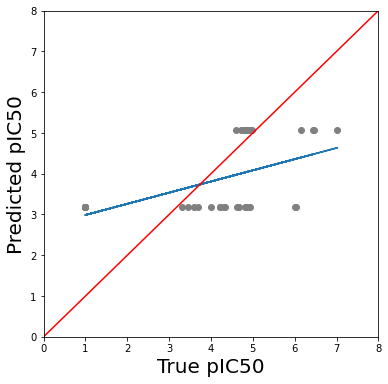

In [96]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred2,color='grey')
m, b = np.polyfit(y_test, y_pred2, 1)
plt.plot(y_test, m*(y_test) + b)
plt.plot(np.linspace(0,10),np.linspace(0,10),color='red')
plt.xlabel('True pIC50',size=20)
plt.ylabel('Predicted pIC50',size=20)
plt.xlim(0,8)
plt.ylim(0,8)
#plt.text(6,7,'y=',fontsize=15,color='red')
plt.show()

## Random Forest

In [252]:
regr_3=RandomForestRegressor(random_state=5)
regr_3.fit(x_train,y_train)
y_pred3=regr_3.predict(x_test)
r2_RF = r2_score(y_test, y_pred3)
mse_RF = mean_squared_error(y_test, y_pred3)
mae_RF = mean_absolute_error(y_test, y_pred3)
print("r2_score:             ", r2_RF)
print("MSE:                  ", mse_RF)
print("MAE:                  ", mae_RF)

r2_score:              0.37833302606771246
MSE:                   1.652794513543051
MAE:                   0.9405930040175874


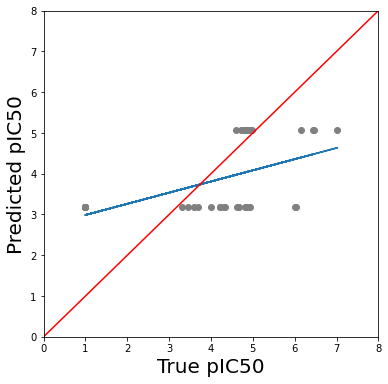

In [106]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred3,color='grey')
m, b = np.polyfit(y_test, y_pred3, 1)
plt.plot(y_test, m*(y_test) + b)
plt.plot(np.linspace(0,10),np.linspace(0,10),color='red')
plt.xlabel('True pIC50',size=20)
plt.ylabel('Predicted pIC50',size=20)
plt.xlim(0,8)
plt.ylim(0,8)
plt.show()

## Support Vector Machine

In [253]:
regr_4=svm.SVR()
regr_4.fit(x_train,y_train)
y_pred4=regr_4.predict(x_test)
r2_SVM = r2_score(y_test, y_pred4)
mse_SVM = mean_squared_error(y_test, y_pred4)
mae_SVM = mean_absolute_error(y_test, y_pred4)
print("r2_score:             ", r2_SVM)
print("MSE:                  ", mse_SVM)
print("MAE:                  ", mae_SVM)

r2_score:              0.3713516605079612
MSE:                   1.6713555167457914
MAE:                   0.919753566743398


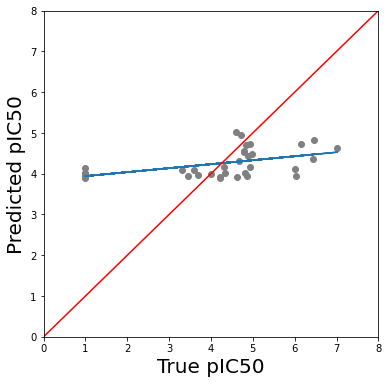

In [111]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred4,color='grey')
m, b = np.polyfit(y_test, y_pred4, 1)
plt.plot(y_test, m*(y_test) + b)
plt.plot(np.linspace(0,10),np.linspace(0,10),color='red')
plt.xlabel('True pIC50',size=20)
plt.ylabel('Predicted pIC50',size=20)
plt.xlim(0,8)
plt.ylim(0,8)
plt.show()

#GRADIENT BOOST

In [254]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor().fit(x_train,y_train)
y_pred5=clf.predict(x_test)
r2_GradientBoostingRegressor = clf.score(x_test, y_pred5)
mse_GradientBoostingRegressor = mean_squared_error(y_test, y_pred5)
mae_GradientBoostingRegressor = mean_absolute_error(y_test, y_pred5)
print("r2_score: ", r2_GradientBoostingRegressor)
print("MSE: ", mse_GradientBoostingRegressor )
print("MAE: ", mae_GradientBoostingRegressor)

r2_score:  1.0
MSE:  1.7767310434004926
MAE:  0.9606850517901242


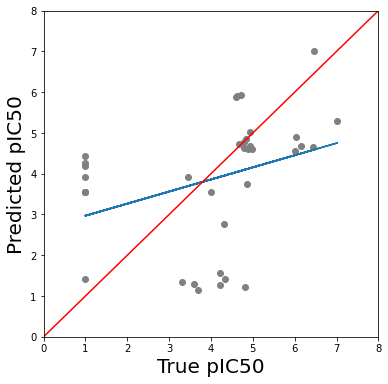

In [117]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred5,color='grey')
m, b = np.polyfit(y_test, y_pred5, 1)
plt.plot(y_test, m*(y_test) + b)
plt.plot(np.linspace(0,10),np.linspace(0,10),color='red')
plt.xlabel('True pIC50',size=20)
plt.ylabel('Predicted pIC50',size=20)
plt.xlim(0,8)
plt.ylim(0,8)
plt.show()

Text(0, 0.5, 'pIC50')

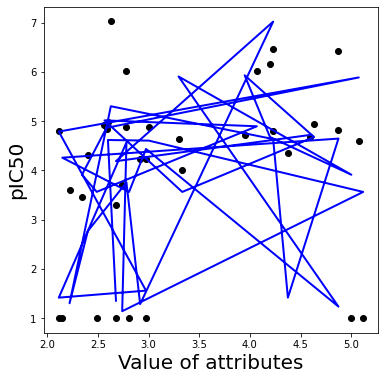

In [142]:
plt.figure(figsize=(6,6))
plt.scatter(xvalueslist+constant,y_test,color='black')
plt.plot(xvalueslist+constant,y_pred5,color='blue', linewidth=2)
plt.xlabel('Value of attributes',size=20)
plt.ylabel('pIC50',size=20)

#Stochastic Gradient Descent Regressor

In [255]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(x_train, y_train)
y_pred6=reg.predict(x_test)
r2_SGD = r2_score(y_test, y_pred6)
mse_SGD = mean_squared_error(y_test, y_pred6)
mae_SGD = mean_absolute_error(y_test, y_pred6)
print("r2_score:             ", r2_SGD)
print("MSE:                  ", mse_SGD)
print("MAE:                  ", mae_SGD)


r2_score:              0.33962355309854886
MSE:                   1.7557094297736584
MAE:                   0.9694509661423205


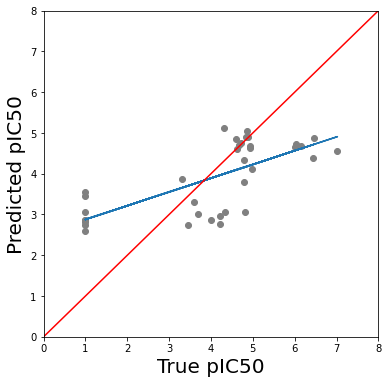

In [125]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred6,color='grey')
m, b = np.polyfit(y_test, y_pred6, 1)
plt.plot(y_test, m*(y_test) + b)
plt.plot(np.linspace(0,10),np.linspace(0,10),color='red')
plt.xlabel('True pIC50',size=20)
plt.ylabel('Predicted pIC50',size=20)
plt.xlim(0,8)
plt.ylim(0,8)
plt.show()

Text(0, 0.5, 'pIC50')

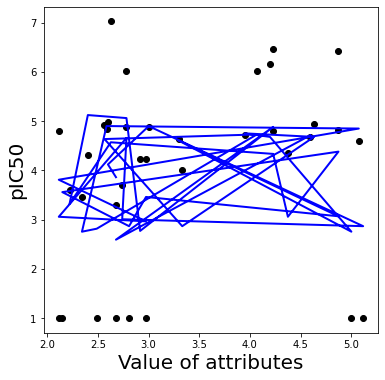

In [143]:
plt.figure(figsize=(6,6))
plt.scatter(xvalueslist+constant,y_test,color='black')
plt.plot(xvalueslist+constant,y_pred6,color='blue', linewidth=2)
plt.xlabel('Value of attributes',size=20)
plt.ylabel('pIC50',size=20)

#Bayesian Ridge

In [256]:
bay = linear_model.BayesianRidge()
bay.fit(x_train,y_train)
y_pred8 = bay.predict(x_test)
r2_score(y_test, y_pred8)
r2_bayessian = r2_score(y_test, y_pred8)
mse_bayessian = mean_squared_error(y_test, y_pred8)
mae_bayessian = mean_absolute_error(y_test, y_pred8)
print("r2_score: ", r2_bayessian)
print("MSE: ", mse_bayessian)
print("MAE: ", mae_bayessian)

r2_score:  0.5138954296705756
MSE:  1.292381613529602
MAE:  0.8995459187557054


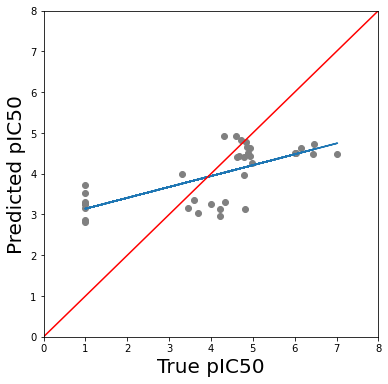

In [139]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred8,color='grey')
m, b = np.polyfit(y_test, y_pred8, 1)
plt.plot(y_test, m*(y_test) + b)
plt.plot(np.linspace(0,10),np.linspace(0,10),color='red')
plt.xlabel('True pIC50',size=20)
plt.ylabel('Predicted pIC50',size=20)
plt.xlim(0,8)
plt.ylim(0,8)
plt.show()

In [257]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
mlpregr = MLPRegressor(random_state=3, max_iter=600).fit(x_train, y_train)
y_pred7 = mlpregr.predict(x_test)
r2_mlpregr = r2_score(y_test, y_pred7)
mse_mlpregr = mean_squared_error(y_test, y_pred7)
mae_mlpregr = mean_absolute_error(y_test, y_pred7)
print("r2_score: ", r2_mlpregr)
print("MSE: ", mse_mlpregr)
print("MAE: ", mae_mlpregr)

r2_score:  0.2863569234904936
MSE:  1.8973267214471146
MAE:  0.9918288661478798


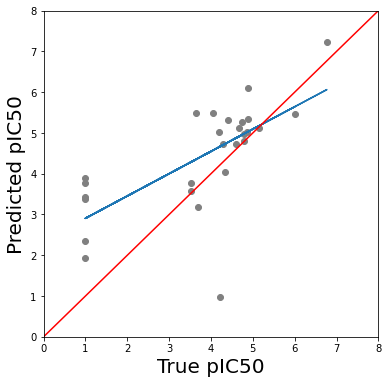

In [258]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred7,color='grey')
m, b = np.polyfit(y_test, y_pred7, 1)
plt.plot(y_test, m*(y_test) + b)
plt.plot(np.linspace(0,10),np.linspace(0,10),color='red')
plt.xlabel('True pIC50',size=20)
plt.ylabel('Predicted pIC50',size=20)
plt.xlim(0,8)
plt.ylim(0,8)
plt.show()

In [295]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(x_train, y_train)
y_pred9 = neigh.predict(x_test)
r2_neigh = r2_score(y_test, y_pred9)
mse_neigh = mean_squared_error(y_test, y_pred9)
mae_neigh = mean_absolute_error(y_test, y_pred9)
print("r2_score: ", r2_neigh)
print("MSE: ", mse_neigh)
print("MAE: ", mae_neigh)

r2_score:  0.2941462282616416
MSE:  1.8766176911625647
MAE:  1.0035474749652127


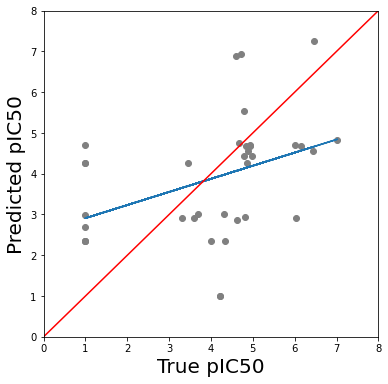

In [152]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred9,color='grey')
m, b = np.polyfit(y_test, y_pred9, 1)
plt.plot(y_test, m*(y_test) + b)
plt.plot(np.linspace(0,10),np.linspace(0,10),color='red')
plt.xlabel('True pIC50',size=20)
plt.ylabel('Predicted pIC50',size=20)
plt.xlim(0,8)
plt.ylim(0,8)
plt.show()

#Ridge CV linear model

In [296]:
from sklearn import linear_model
redg = linear_model.RidgeCV(alphas=np.logspace().fit(x_train,y_train)
y_predf = redg.predict(x_test)
r2_ridge = r2_score(y_test, y_predf)
mse_ridge = mean_squared_error(y_test, y_predf)
mae_ridge = mean_absolute_error(y_test, y_predf)
print("r2_score: ", r2_ridge)
print("MSE: ", mse_ridge)
print("MAE: ", mae_ridge)

SyntaxError: ignored

In [267]:
from sklearn.svm import SVR
clf = SVR()
clf.fit(x_train,y_train)
y_pred_clf = clf.predict(x_test)
r2_svr1 = r2_score(y_test, y_pred_clf)
mse_svr1 = mean_squared_error(y_test, y_pred_clf)
mae_svr1 = mean_absolute_error(y_test, y_pred_clf)
print("r2_score: ", r2_svr1)
print("MSE: ", mse_svr1)
print("MAE: ", mae_svr1)

r2_score:  0.3713516605079612
MSE:  1.6713555167457914
MAE:  0.919753566743398


#COMPARISON OF DIFFERENT MODELS

In [298]:
lr = ["Linear Regression model", r2_lr, mse_lr, mae_lr]
ridge = ["Ridge CV model", r2_ridge, mse_ridge, mae_ridge]
bayessian = ["Bayessian Ridge model", r2_bayessian, mse_bayessian, mae_bayessian]
svr1 = ["SVM model", r2_SVM, mse_SVM, mae_SVM]
svr = ["SVR model", r2_svr1, mse_svr1, mae_svr1]
RF = ["Random Forest", r2_RF, mse_RF, mae_RF]
DT = ["Decision Tree", r2_DT, mse_DT, mae_DT]
GB = ["Gradient Boost", r2_GradientBoostingRegressor, mse_GradientBoostingRegressor, mae_GradientBoostingRegressor]
SGD =["Stochastic Gradient Regressor", r2_SGD, mse_SGD, mae_SGD]
data = [GB, SGD, lr, bayessian, DT,  RF, svr1, svr, ridge]
df1 = pd.DataFrame(data, columns = ['Model', 'r2 score', 'MSE', 'MAE'])
df1

,Model,r2 score,MSE,MAE
0,Gradient Boost,1.000000e+00,1.776731e+00,9.606851e-01
1,Stochastic Gradient Regressor,3.396236e-01,1.755709e+00,9.694510e-01
2,Linear Regression model,-3.496887e+24,9.296996e+24,1.827761e+12
3,Bayessian Ridge model,5.138954e-01,1.292382e+00,8.995459e-01
4,Decision Tree,5.071403e-01,1.310341e+00,1.008495e+00
5,Random Forest,3.783330e-01,1.652795e+00,9.405930e-01
6,SVM model,3.713517e-01,1.671356e+00,9.197536e-01
7,SVR model,3.713517e-01,1.671356e+00,9.197536e-01
8,Ridge CV model,-3.068508e-02,3.316892e+00,1.505451e+00


# Classification Models (as active or inactive compound)

## K Nearest Neighbour 

In [153]:
df_2class[['bioactivity_class','MW','LogP','NumHDonors','NumHAcceptors']]

,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
2,inactive,421.190,2.66050,0.0,4.0
3,inactive,293.347,3.63080,0.0,3.0
5,active,372.243,4.39330,0.0,3.0
7,active,419.243,4.23540,0.0,3.0
8,inactive,327.792,4.28420,0.0,3.0
...,...,...,...,...,...
128,inactive,338.359,3.40102,0.0,5.0
129,inactive,296.366,3.44330,0.0,3.0
130,inactive,276.291,4.09564,0.0,3.0
131,inactive,278.307,3.29102,0.0,3.0


In [154]:
X_train, X_test, Y_train, Y_test = train_test_split(df_2class[['MW','LogP','NumHDonors','NumHAcceptors']],  df_2class['bioactivity_class'],test_size=0.30, random_state=5)
print(f'train: {x_train.size}')
print(f'test: {x_test.size}')

train: 332
test: 144


In [155]:
from sklearn.neighbors import KNeighborsClassifier
# Initialize our classifier
knn = KNeighborsClassifier(n_neighbors=2, weights='distance' )
# Fitting the model with the data
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='distance')

In [156]:
Y_pred = knn.predict(X_test)
print(Y_pred)
print(Y_test.values)

['inactive' 'inactive' 'inactive' 'active' 'inactive' 'inactive'
 'inactive' 'inactive' 'inactive' 'inactive' 'inactive' 'inactive'
 'inactive' 'inactive' 'inactive' 'inactive' 'inactive' 'inactive'
 'inactive' 'inactive' 'inactive' 'inactive' 'inactive' 'inactive'
 'inactive' 'inactive' 'active' 'inactive' 'inactive' 'inactive'
 'inactive' 'inactive' 'inactive' 'inactive' 'inactive' 'inactive']
['inactive' 'inactive' 'inactive' 'inactive' 'inactive' 'inactive'
 'inactive' 'inactive' 'inactive' 'inactive' 'inactive' 'inactive'
 'inactive' 'inactive' 'inactive' 'inactive' 'inactive' 'active'
 'inactive' 'inactive' 'inactive' 'inactive' 'inactive' 'inactive'
 'inactive' 'inactive' 'active' 'inactive' 'inactive' 'inactive'
 'inactive' 'inactive' 'inactive' 'active' 'inactive' 'inactive']


In [157]:
from sklearn import metrics
print("Confusion matrix of the predictions:\n", metrics.confusion_matrix(Y_test, Y_pred))
print("accuracy of the predictions:", metrics.accuracy_score(Y_test, Y_pred))
print("precision", metrics.precision_score(Y_test, Y_pred, average=None))

Confusion matrix of the predictions:
 [[ 1  2]
 [ 1 32]]
accuracy of the predictions: 0.9166666666666666
precision [0.5        0.94117647]


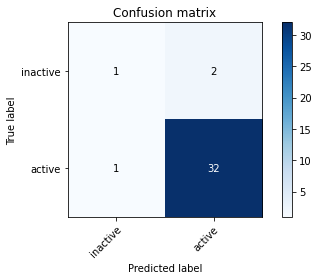

In [158]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(Y_true, Y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
 
    # Compute confusion matrix
    cm = confusion_matrix(Y_true, Y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred, classes= df_2class['bioactivity_class'].unique(),
                      title='Confusion matrix')

plt.show()

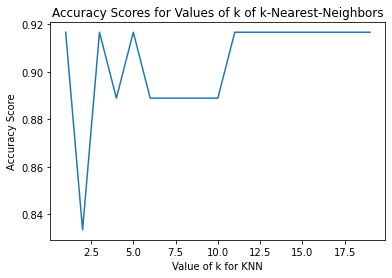

In [160]:
k_range = list(range(1,20))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(Y_test, Y_pred))
    
plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

Text(0, 0.5, 'Frequency')

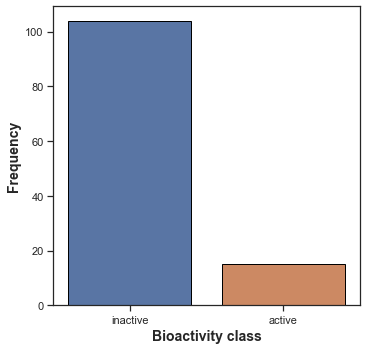

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

### **Scatter plot of MW versus LogP, NumHDonors and NumHAcceptors**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

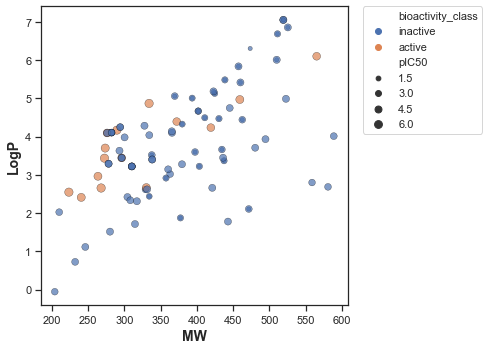

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

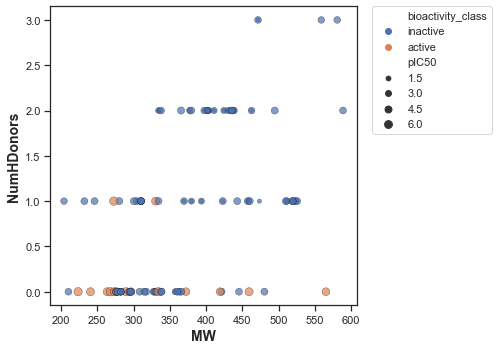

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.scatterplot(x='MW', y='NumHDonors', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

The active compounds are of lower molecular weight and also have lesser number of hydrogen bond donors as seen in the above plot. This also aligns with the Lipinski rule of HBD < 5. 

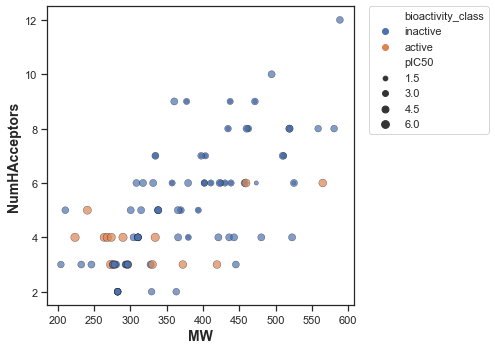

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.scatterplot(x='MW', y='NumHAcceptors', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Similarly, the active compounds have lesser number of hydrogen bond acceptors as seen in the plot above. This also aligns with the Lipinski rule of HBA < 10.

### **Box plots**

#### **pIC50 value**

Text(0, 0.5, 'pIC50 value')

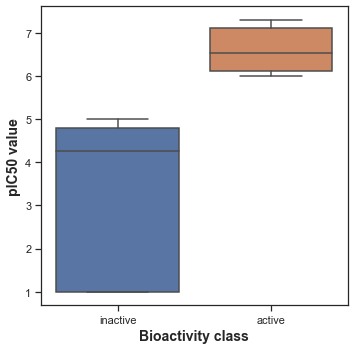

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

In [ ]:

! zip -r results.zip . -i *.csv *.pdf

#### **Interpretation**

The difference in pIC50 values is expected as threshold values of IC50 were used to classify the compounds as active or inactive